In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [2]:
import os
file_path = 'data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
45777,Tom forgot to salute.,Tom oublia de saluer.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
181757,Why didn't you tell us that there was a witness?,Que ne nous as-tu pas dit qu'il y avait un tém...,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
125162,It may well rain before tonight.,Il va certainement pleuvoir avant ce soir.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
6407,Who built it?,Qui l'a bâtie ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
179881,There is a nice park in the center of the town.,Il y a un chouette parc au centre de la ville.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


# Step0. 33,000개의 샘플만 사용

In [3]:
lines = lines[['eng', 'fra']][:33000] # 3만3000개 샘플 사용
lines.sample(5)

,eng,fra
20410,Stop showing off!,Arrêtez de frimer !
28922,"Get real, will you?","Soyez réaliste, voulez-vous ?"
9282,We're winners.,Nous sommes des gagneurs.
16400,Tom seems angry.,Tom semble énervé.
18601,I drive a hybrid.,Je conduis un véhicule hybride.


In [4]:
lines.count()

eng    33000
fra    33000
dtype: int64

In [5]:
lines.head(5)

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


# Step1. 정제,정규화,전처리 및 프랑스어 시작 ,끝 문자추가
구두점(Punctuation)을 단어와 분리<br>
소문자로 변경<br>
띄어쓰기 단위로 토큰 수행<br>

In [6]:
import re
def preprocess_sentence(sentence,is_decoder=False):
    sentence = sentence.lower().strip() # 대문자를 소문자로, 양쪽공백 지우기
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자 양쪽에 공백넣기
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로 바꾼다
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # a-zA-Z>.!,¿가 아닌 모든 문자를 하나의 공백으로 변경
    sentence = sentence.strip() # 다시왼쪽 공백을 지운다
    if is_decoder: # 디코더 인 경우만 수행
        sentence = '<start> ' + sentence + ' <end>' # 문장 시작<start>, 끝에는<end> 추가
    return sentence

In [7]:
lines.eng = lines.eng.apply(preprocess_sentence,is_decoder=False)

In [8]:
lines.head(5)

,eng,fra
0,go .,Va !
1,go .,Marche.
2,go .,En route !
3,go .,Bouge !
4,hi .,Salut !


### 프랑스어는 시작과 끝을 넣는다

In [9]:
lines.fra = lines.fra.apply(preprocess_sentence,is_decoder=True)

In [10]:
lines.head(5)

,eng,fra
0,go .,<start> va ! <end>
1,go .,<start> marche . <end>
2,go .,<start> en route ! <end>
3,go .,<start> bouge ! <end>
4,hi .,<start> salut ! <end>


### Tokenizer는 !?. 를 포함하도록 수정

In [11]:
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' default값에서 !?.<> 만 제외시킨 필터 적용
eng_tokenizer = Tokenizer(filters='"#$%&()*+,-/:;=@[\\]^_`{|}~\t\n')
eng_tokenizer.fit_on_texts(lines.eng)

In [12]:
fra_tokenizer = Tokenizer(filters='"#$%&()*+,-/:;=@[\\]^_`{|}~\t\n')
fra_tokenizer.fit_on_texts(lines.fra)

In [13]:
eng_tokenizer.word_index['.']

1

In [14]:
fra_tokenizer.word_index['!']

8

# Step2. 케라스의 토크나이저로 텍스트를 숫자로 변경
## tokenizer.text_to_sequences() 사용

In [15]:
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:10]

[[28, 1],
 [28, 1],
 [28, 1],
 [28, 1],
 [761, 1],
 [761, 1],
 [196, 23],
 [196, 23],
 [196, 23],
 [196, 23]]

In [16]:
for sentence in input_text[:10]:
    for idx in sentence:
        print(eng_tokenizer.index_word[idx],end=' ')
    print('')

go . 
go . 
go . 
go . 
hi . 
hi . 
run ! 
run ! 
run ! 
run ! 


In [17]:
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:10]

[[1, 75, 8, 2],
 [1, 365, 3, 2],
 [1, 28, 512, 8, 2],
 [1, 716, 8, 2],
 [1, 750, 8, 2],
 [1, 750, 3, 2],
 [1, 663, 8, 2],
 [1, 1879, 8, 2],
 [1, 178, 267, 1043, 267, 2620, 8, 2],
 [1, 1487, 8, 2]]

In [18]:
for sentence in target_text[:10]:
    for idx in sentence:
        print(fra_tokenizer.index_word[idx],end=' ')
    print('')

<start> va ! <end> 
<start> marche . <end> 
<start> en route ! <end> 
<start> bouge ! <end> 
<start> salut ! <end> 
<start> salut . <end> 
<start> cours ! <end> 
<start> courez ! <end> 
<start> prenez vos jambes vos cous ! <end> 
<start> file ! <end> 


In [19]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4671
프랑스어 단어장의 크기 : 7454


In [20]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [21]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4671
프랑스어 단어장의 크기 : 7454
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [22]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ word for word in line if word != fra_tokenizer.word_index['<end>'] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ word for word in line if word != fra_tokenizer.word_index['<start>'] ] for line in target_text]

In [23]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')

In [24]:
print(encoder_input[0])
print(encoder_input.shape)
print(decoder_input[0])
print(decoder_input.shape)
print(decoder_target[0])
print(decoder_target.shape)

[28  1  0  0  0  0  0  0]
(33000, 8)
[ 1 75  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(33000, 17)
[75  8  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(33000, 17)


In [25]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

print('영어 테스트 데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 테스트 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 테스트 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

영어 학습데이터의 크기(shape) : (30000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 17)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 17)
영어 테스트 데이터의 크기(shape) : (3000, 8)
프랑스어 테스트 입력데이터의 크기(shape) : (3000, 17)
프랑스어 테스트 출력데이터의 크기(shape) : (3000, 17)


# Step3. 임베딩 층(Embedding layer)사용하기
주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만,
디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 합니다!

In [26]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

embedding_vector_dim = 500
hidden_size = 256

encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(input_dim=eng_vocab_size, 
                     output_dim=embedding_vector_dim,
                     input_length=max_eng_seq_len)(encoder_inputs)

encoder_masking =Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_masking)
encoder_states = [state_h, state_c]

In [27]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer =  Embedding(input_dim=fra_vocab_size, 
                     output_dim=embedding_vector_dim,
                     input_length=max_fra_seq_len)

dec_emb_out = dec_emb_layer(decoder_inputs)
decoder_masking =Masking(mask_value=0.0)(dec_emb_out)
decoder_lstm = LSTM(hidden_size,return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_masking, initial_state = encoder_states)
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs_last = decoder_softmax_layer(decoder_outputs)

# Step5. 모델구현

In [28]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_last)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 500)    2335500     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 500)    3727000     input_2[0][0]                    
______________________________________________________________________________________________

In [29]:
history=model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=20)

Epoch 1/20
235/235 [==============================] - 23s 70ms/step - loss: 1.7693 - val_loss: 1.6800
Epoch 2/20
235/235 [==============================] - 14s 61ms/step - loss: 1.2310 - val_loss: 1.4184
Epoch 3/20
235/235 [==============================] - 15s 62ms/step - loss: 1.0387 - val_loss: 1.2923
Epoch 4/20
235/235 [==============================] - 15s 62ms/step - loss: 0.9201 - val_loss: 1.2054
Epoch 5/20
235/235 [==============================] - 15s 62ms/step - loss: 0.8309 - val_loss: 1.1542
Epoch 6/20
235/235 [==============================] - 14s 62ms/step - loss: 0.7602 - val_loss: 1.1077
Epoch 7/20
235/235 [==============================] - 14s 61ms/step - loss: 0.7009 - val_loss: 1.0799
Epoch 8/20
235/235 [==============================] - 14s 62ms/step - loss: 0.6487 - val_loss: 1.0393
Epoch 9/20
235/235 [==============================] - 14s 61ms/step - loss: 0.6018 - val_loss: 1.0262
Epoch 10/20
235/235 [==============================] - 14s 62ms/step - loss: 0.561

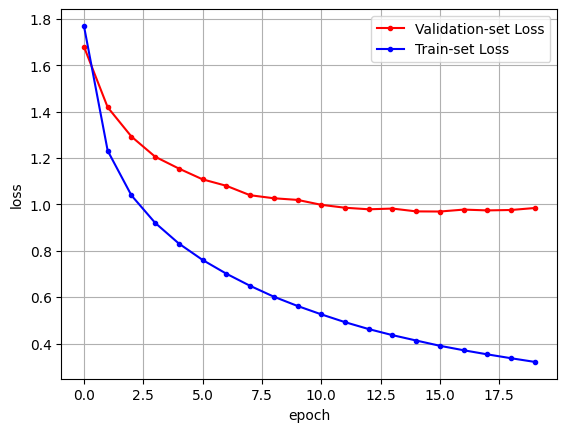

In [32]:
import matplotlib.pyplot as plt
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Step6. 모델평가

In [33]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 500)         2335500   
_________________________________________________________________
masking (Masking)            (None, None, 500)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 775168    
Total params: 3,110,668
Trainable params: 3,110,668
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_size,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb_out_test = dec_emb_layer(decoder_inputs)
# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs_test, state_h_test, state_c_test = decoder_lstm(dec_emb_out_test, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states_test = [state_h_test, state_c_test]

In [35]:
decoder_outputs_test_last = decoder_softmax_layer(decoder_outputs_test)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, 
                      outputs=[decoder_outputs_test_last] + decoder_states_test)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 500)    3727000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [36]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [37]:
len(idx2fra)

7453

In [40]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <start>에 해당하는벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_word

        # <end>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_word == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [44]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index])
    print('번역기가 번역한 문장:', decoded_sentence)

-----------------------------------
입력 문장: go .
정답 문장: <start> bouge ! <end>
번역기가 번역한 문장:  va y ! <end>
-----------------------------------
입력 문장: hello !
정답 문장: <start> bonjour ! <end>
번역기가 번역한 문장:  bonjour ! <end>
-----------------------------------
입력 문장: got it ?
정답 문장: <start> t as capt ? <end>
번역기가 번역한 문장:  a t il ? <end>
-----------------------------------
입력 문장: hang on .
정답 문장: <start> tiens bon ! <end>
번역기가 번역한 문장:  attendez . <end>
-----------------------------------
입력 문장: here s .
정답 문장: <start> voil cinq dollars . <end>
번역기가 번역한 문장:  tenez vous en voil


-----------------------------------
입력 문장: go .
정답 문장: <start> bouge ! <end>
번역기가 번역한 문장:  va y ! <end>
정답 문장      ->한글: 이동하다!
번역기 번역문장->한글: 가다!
-----------------------------------
입력 문장: hello !
정답 문장: <start> bonjour ! <end>
번역기가 번역한 문장:  bonjour ! <end>
정답 문장      ->한글: 여보세요 !
번역기 번역문장->한글: 여보세요 !
-----------------------------------
입력 문장: got it ?
정답 문장: <start> t as capt ? <end>
번역기가 번역한 문장:  a t il ? <end>
정답 문장      ->한글: 잡았어?
번역기 번역문장->한글: 그는 가지고 있습니까?
-----------------------------------
입력 문장: hang on .
정답 문장: <start> tiens bon ! <end>
번역기가 번역한 문장:  attendez . <end>
정답 문장      ->한글: 기다리다 !
번역기 번역문장->한글: 기다리다 .
-----------------------------------
입력 문장: here s .
정답 문장: <start> voil cinq dollars . <end>
번역기가 번역한 문장:  tenez vous en voil
정답 문장      ->한글: 여기 5달러입니다.
번역기 번역문장->한글: 기다리다